In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [152]:
def generate_er_graph(n_nodes, n_edges, n_clusters, feature_dim,noise_std):
    # Create an empty graph
    G = nx.Graph()

    # Add nodes to the graph
    G.add_nodes_from(range(n_nodes))

    # Generate edges using the Erdős-Rényi model
    edge_prob = n_edges / (n_nodes * (n_nodes - 1) / 2)
    G = nx.erdos_renyi_graph(n_nodes, edge_prob)

    # Assign each node to a cluster
    clusters = np.random.choice(n_clusters, n_nodes)
    for node in G.nodes():
        G.nodes[node]['cluster'] = clusters[node]
    sum_squared_noise = 0  # Initialize sum of squared noise
    # Initialize feature vectors and parameter vectors for each node
    for node in G.nodes():
        # Assign feature vector
        G.nodes[node]['feature'] = 1*np.random.choice([-1, 1], size=feature_dim)
        # Assign parameter vector - identical for all nodes in the same cluster
        cluster_id = clusters[node]
        if 'param_vector' not in G.graph or cluster_id not in G.graph['param_vector']:
            G.graph.setdefault('param_vector', {})[cluster_id] = np.random.rand(feature_dim)
        G.nodes[node]['param'] = G.graph['param_vector'][cluster_id]
        noise = np.random.normal(0, noise_std)  # Gaussian noise, mean = 0, std = 0.1
    # Compute the label y = x'w + noise
        G.nodes[node]['label'] = np.dot(G.nodes[node]['feature'] , G.nodes[node]['param']) + noise
        
        sum_squared_noise += noise**2  # Sum of squared noise
    return G,sum_squared_noise

In [153]:
def draw_graph(G):
    # Get cluster information
    clusters = [G.nodes[n]['cluster'] for n in G.nodes()]
    unique_clusters = list(set(clusters))
    color_map = {cluster: i for i, cluster in enumerate(unique_clusters)}

    # Map colors
    node_colors = [color_map[cluster] for cluster in clusters]

    # Draw the graph
    pos = nx.spring_layout(G)  # positions for all nodes
    ec = nx.draw_networkx_edges(G, pos, alpha=0.2)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color=node_colors, 
                                 node_size=100, cmap=plt.cm.jet)
  #  plt.colorbar(nc)
    plt.axis('off')
    plt.show()

In [154]:
def compute_fiedler_value(G):
    # Compute the Laplacian matrix of the graph
    L = nx.laplacian_matrix(G).astype(float)
    # Calculate eigenvalues
    eigenvalues = np.linalg.eigvalsh(L.todense())
    # The eigenvalues are sorted, the second smallest is the Fiedler value
    return eigenvalues[1]

In [155]:
# Function to compute the total variation
def total_variation(graph):
    total_var = 0.0
    for u, v in graph.edges():
        node_u_val = graph.nodes[u]['value']
        node_v_val = graph.nodes[v]['value']
        diff = node_u_val - node_v_val
        total_var += np.linalg.norm(diff) ** 2  # Squared Euclidean distance
    return total_var

In [156]:
from scipy.linalg import block_diag
import cvxpy as cp
from scipy.sparse import kron

# this function constructs the matrix Q and vector q for the quadratic 
# form that represents the GTVMin objective function for local linear models. 

def compute_q_matrix_and_vector(graph, regparam):
    # List to hold the blocks of the block diagonal matrix
    blocks = []
    vector_q = np.empty((0, 1))
    nr_features = len(graph.nodes[1]['feature'])
    # Iterate over the nodes
    for node in graph.nodes(data=True):
        x = np.array(node[1]['feature'])
        y = node[1]['label']
        # Calculate x*(y - x'*w) (adjusted to correct form)
        w = node[1]['param']
        vector_q = np.vstack((vector_q, -2 * y * x.reshape(-1, 1)))
        block = np.outer(x, x)
        # Append the block to the list of blocks
        blocks.append(block)

    # Create the block diagonal matrix
    block_matrix = block_diag(*blocks)
    
    # Compute the Laplacian matrix of the graph
    L = nx.laplacian_matrix(graph).toarray()

    # Specify the size of the identity matrix based on the feature vector dimension
    I = np.identity(nr_features)

    # This is a Kronecker product between the Laplacian matrix and the identity matrix
    K = kron(L, I)

    # Compute Q matrix using the regularization parameter and the Kronecker product
    Q = regparam * K + block_matrix

    return Q, vector_q

In [157]:
# Function to calculate the squared Euclidean norm of the difference of an attribute across an edge
def squared_euclidean_norm_difference(G, u, v, attr):
    return np.sum((G.nodes[u][attr] - G.nodes[v][attr])**2)

In [228]:
import random
# Parameters
number_of_nodes = 100  # e.g., 100 nodes
number_of_clusters = 1 # e.g., 5 clusters
feature_vector_dimension = 1  # e.g., feature vector of dimension 10
nr_runs = 10


lower_bound = int(np.ceil(2 * number_of_nodes))
upper_bound = int(np.ceil(20 * number_of_nodes))

nr_edges_values = np.rint(np.linspace(lower_bound, upper_bound, num=nr_runs))


vals_tv = np.zeros((nr_runs,1)) 
vals_fiedler = np.zeros((nr_runs,1))
vals_tildeerr = np.zeros((nr_runs,1))
vals_bound = np.zeros((nr_runs,1))

for iter_runs in range(nr_runs): 
    number_of_edges = nr_edges_values[iter_runs] #random.randint(lower_bound, upper_bound)
# Generate the graph
    graph,epsilon_cluster = generate_er_graph(number_of_nodes, number_of_edges, number_of_clusters, feature_vector_dimension,0.5)

  #  print(nx.laplacian_matrix(graph).toarray())
    # Draw the graph with nodes colored by cluster ID
  #  draw_graph(graph)
    # Compute the Fiedler value (second smallest eigenvalue of the Laplacian)
    fiedler_value = compute_fiedler_value(graph)
    
    print("Fiedler value: {:.2f}".format(fiedler_value))  # Adjust "2" to your desired number of decimal places
    # regularization parameter
    regparam = 10
    Q, vector_q = compute_q_matrix_and_vector(graph, regparam)
    # Define the optimization variable
    w = cp.Variable(feature_vector_dimension*number_of_nodes)
    # Define the objective function
    objective = cp.Minimize(cp.quad_form(w, Q) + vector_q.T @ w)
    # Define the problem and solve it
    problem = cp.Problem(objective)
    problem.solve()
    est_params = w.value.reshape((-1,feature_vector_dimension))
    if (fiedler_value*regparam)> 0.0000000001 : 
        vals_bound[iter_runs] = epsilon_cluster/(fiedler_value*regparam)
    vals_fiedler[iter_runs] = fiedler_value*regparam
    # Compute the average row
    average_row = est_params.mean(axis=0)

    # Subtract the average row from each row in est_params
    normalized_est_params = est_params - average_row

    # as sanity check, evalute gradient at the delivered solution 
    #result = 2*Q @ w.value.reshape(-1,1) + vector_q
    #print(result)
    #for iter_node in range(number_of_nodes):
    #    graph.nodes[iter_node]['estparam'] = est_params[iter_node, :]

    vals_tildeerr[iter_runs] = np.sum(np.linalg.norm(normalized_est_params, ord=2, axis=1)**2)
    #vals_tv[iter_runs] = sum_squared_diff*regparam


# Output the optimal value of w
#print("The minimizer w is:", w.value.reshape((-1,feature_vector_dimension)))
#print("The minimum value of the objective function is:", problem.value)

Fiedler value: 0.50
Fiedler value: -0.00
Fiedler value: 5.01
Fiedler value: 6.78
Fiedler value: 8.25
Fiedler value: 13.78
Fiedler value: 16.97
Fiedler value: 16.19
Fiedler value: 24.26
Fiedler value: 26.07


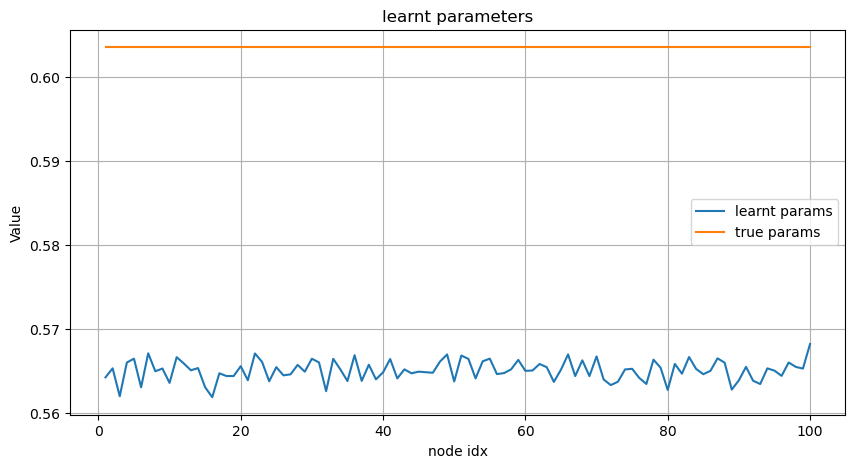

In [229]:
# Initialize a NumPy array for storing parameters
true_params = np.empty(graph.number_of_nodes(), dtype=float)

# Extract 'param' attributes into the array
for node in graph.nodes():
    true_params[node] = graph.nodes[node]['param']

plt.figure(figsize=(10, 5))  # Set the figure size
plt.plot(range(1, len(est_params) + 1),est_params, label='learnt params')  # Plot the data
plt.plot(range(1, len(est_params) + 1),true_params, label='true params')  # Plot the data
plt.title('learnt parameters')  # Title of the plot
plt.xlabel('node idx')  # Label for the x-axis
plt.ylabel('Value')  # Label for the y-axis
plt.legend()  # Add a legend
plt.grid(True)  # Add gridlines
plt.show()  # Display the plot

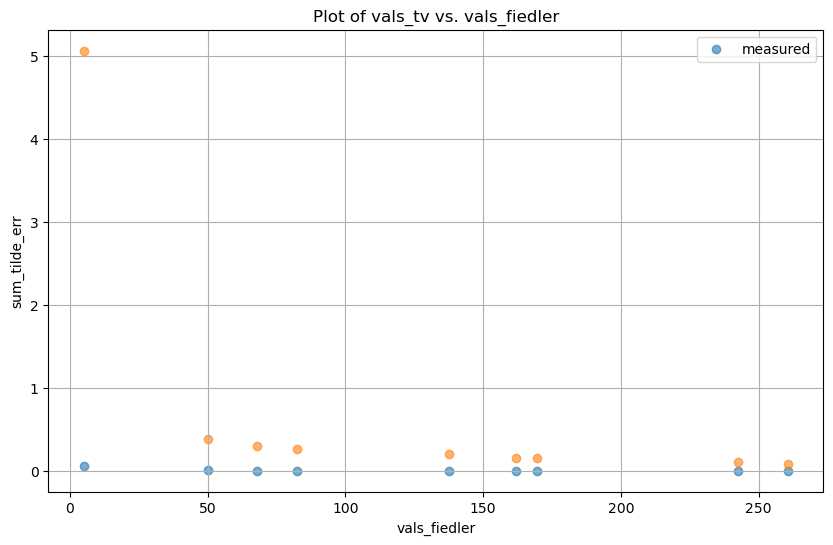

In [231]:
# Plotting

# Stack fiedler_vals, bound vals and measured clustering error 
# into rows of numpay array stacked_array 
stacked_array = np.column_stack((vals_fiedler,vals_bound, vals_tildeerr))
# filter out those runs where vals_fiedler is sufficiently large ( >= 0.0001)
mask = stacked_array[:, 0] >= 0.0001
# Apply the mask to filter the array
filtered_array = stacked_array[mask]

plt.figure(figsize=(10, 6))
plt.scatter(filtered_array[:,0], filtered_array[:,2], alpha=0.6,label="measured")  # Scatter plot of measured clustering error
plt.scatter(filtered_array[:,0], filtered_array[:,1], alpha=0.6)  # Scatter plot of the values
plt.title('Plot of vals_tv vs. vals_fiedler')
plt.xlabel('vals_fiedler')
plt.ylabel('sum_tilde_err')
plt.legend()
plt.grid(True)
plt.show()

In [232]:
import pandas as pd 



# Convert the 2D array to a pandas DataFrame
df = pd.DataFrame(filtered_array, columns=['regparamfiedler','bound', 'measured'])

# Save the DataFrame to a CSV file
df.to_csv('bound_measured_err.csv', index=False)